<a href="https://colab.research.google.com/github/Aelamin19/Applied-predictive-analytics/blob/main/APA_Project_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiple datasets will be used
#Each dataset will go through analysis before the datasets are merged and the combined dataset will be prepared and used to create the ML models

#Importing libraries

In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import pydot
from six import StringIO
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
import xgboost as xgb

#Importing the data

In [3]:
rent_df = pd.read_csv("/content/avg monthly rent 2008-2022.csv")
d_i_df = pd.read_csv("/content/Disposable income.csv")
h_p_df = pd.read_csv("/content/House purchases.csv")

In [4]:
rent_df.head()

,STATISTIC Label,Year,Number of Bedrooms,Property Type,Location,UNIT,VALUE
0,RTB Average Monthly Rent Report,2008,One bed,All property types,Carlow,Euro,592.46
1,RTB Average Monthly Rent Report,2008,One bed,All property types,Cavan,Euro,432.78
2,RTB Average Monthly Rent Report,2008,One bed,All property types,Clare,Euro,528.09
3,RTB Average Monthly Rent Report,2008,One bed,All property types,Cork,Euro,666.74
4,RTB Average Monthly Rent Report,2008,One bed,All property types,Donegal,Euro,434.79


In [5]:
d_i_df.head()

,Statistic Label,Year,County,UNIT,VALUE
0,Disposable Income per Person,2000,Co. Carlow,Euro,11648.31
1,Disposable Income per Person,2000,Co. Cavan,Euro,11032.89
2,Disposable Income per Person,2000,Co. Clare,Euro,12190.60
3,Disposable Income per Person,2000,Co. Cork,Euro,12170.97
4,Disposable Income per Person,2000,Co. Donegal,Euro,10246.59


In [6]:
h_p_df.head()

,Statistic Label,Month,Type of Dwelling,Dwelling Status,Stamp Duty Event,RPPI Region,UNIT,VALUE
0,Mean Sale Price,2010 January,Apartment,New,Filings,Border Excluding Louth,Euro,170250.0
1,Mean Sale Price,2010 January,Apartment,New,Filings,Cavan,Euro,NaN
2,Mean Sale Price,2010 January,Apartment,New,Filings,Donegal,Euro,NaN
3,Mean Sale Price,2010 January,Apartment,New,Filings,Leitrim,Euro,NaN
4,Mean Sale Price,2010 January,Apartment,New,Filings,Monaghan,Euro,NaN


#Data preprocessing - Rent df

In [7]:
rent_df['Property Type'].unique()

array(['All property types', 'Detached house', 'Semi detached house',
       'Terrace house', 'Apartment', 'Other flats'], dtype=object)

In [8]:
rent_df['Location'].unique()

array(['Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin', 'Galway',
       'Kerry', 'Kildare', 'Kilkenny', 'Laois', 'Leitrim', 'Limerick',
       'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly',
       'Roscommon', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
       'Wexford', 'Wicklow'], dtype=object)

In [9]:
#The 'All properties' value is not needed, so it will be removed
rent_df = rent_df.drop(rent_df[rent_df['Property Type'] == 'All property types'].index)

In [10]:
#Now, unnecessary columns will be removed
rent_df = rent_df.drop("STATISTIC Label", axis = "columns")
rent_df = rent_df.drop("UNIT", "columns")

<ipython-input-10-b7cb56f57882>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rent_df = rent_df.drop("UNIT", "columns")


In [11]:
#null values
rent_df.isna().sum()

Year                     0
Number of Bedrooms       0
Property Type            0
Location                 0
VALUE                 2753
dtype: int64

In [12]:
#The rows with null values will be removed
rent_df.dropna(subset=["VALUE"], inplace=True)

##creating a "regions" column

In [13]:
#try with * if not working
def get_region(county, region):
    if county in region["Dublin"]:
        return 'Dublin'
    if county in region["Border"]:
        return 'Border'
    elif county in region["West"]:
        return 'West'
    elif county in region["Mid_West"]:
        return 'Mid_West'
    elif county in region["Mid_East"]:
        return 'Mid_East'
    elif county in region["South_East"]:
        return 'South_East'
    elif county in region["South_West"]:
        return 'South_West'
    elif county in region["Midland"]:
        return "Midland"
    else:
        return None

In [14]:
Dublin = ["Dublin", "Dún Laoghaire-Rathdown", "South-Dublin", "Fingal"]
Border = ["Cavan", "Donegal", "Leitrim", "Monaghan", "Sligo"]
West = ["Mayo", "Roscommon", "Galway"]
Mid_West = ["Clare", "Tipperary", "Limerick"]
Mid_East = ["Kildare", "Louth", "Meath", "Wicklow"]
South_East = ["Carlow", "Kilkenny", "Wexford", "Waterford"]
South_West = ["Kerry", "Cork"]
Midland = ["Laois", "Longford", "Offaly", "Westmeath"]

In [15]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
rent_df['region'] = rent_df["Location"].apply(get_region, args=(region,))
rent_df.head(10)

,Year,Number of Bedrooms,Property Type,Location,VALUE,region
29,2008,One bed,Detached house,Cork,556.54,South_West
31,2008,One bed,Detached house,Dublin,1031.97,Dublin
32,2008,One bed,Detached house,Galway,518.02,West
55,2008,One bed,Semi detached house,Cork,624.69,South_West
57,2008,One bed,Semi detached house,Dublin,855.05,Dublin
58,2008,One bed,Semi detached house,Galway,583.32,West
60,2008,One bed,Semi detached house,Kildare,647.66,Mid_East
64,2008,One bed,Semi detached house,Limerick,679.03,Mid_West
77,2008,One bed,Semi detached house,Wicklow,785.52,Mid_East
81,2008,One bed,Terrace house,Cork,657.28,South_West


In [16]:
rent_df.rename(columns = {"VALUE": "rent_value"},
          inplace = True)

In [17]:
#The columns with counties will now be removed because the regions are much better to work with
rent_df = rent_df.drop("Location", "columns")

<ipython-input-17-4447c8f44b60>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rent_df = rent_df.drop("Location", "columns")


In [18]:
rent_df.head(10)

,Year,Number of Bedrooms,Property Type,rent_value,region
29,2008,One bed,Detached house,556.54,South_West
31,2008,One bed,Detached house,1031.97,Dublin
32,2008,One bed,Detached house,518.02,West
55,2008,One bed,Semi detached house,624.69,South_West
57,2008,One bed,Semi detached house,855.05,Dublin
58,2008,One bed,Semi detached house,583.32,West
60,2008,One bed,Semi detached house,647.66,Mid_East
64,2008,One bed,Semi detached house,679.03,Mid_West
77,2008,One bed,Semi detached house,785.52,Mid_East
81,2008,One bed,Terrace house,657.28,South_West


##Changing categorical columns to become useful

In [19]:
rent_df = rent_df.drop(rent_df[rent_df['Number of Bedrooms'] == '1 to 2 bed'].index)
rent_df = rent_df.drop(rent_df[rent_df['Number of Bedrooms'] == '1 to 3 bed'].index)
#Lets now assign weights for the number of bedrooms
rent_df["Number of Bedrooms"] = rent_df["Number of Bedrooms"].map({"Four plus bed": 4,
                                                                   "Three bed": 3,
                                                                   "Two bed": 2,
                                                                   "One bed": 1})

In [20]:
#rent_df = rent_df.join(pd.get_dummies(rent_df["Number of Bedrooms"])).drop(["Number of Bedrooms"], axis=1)
rent_df = rent_df.join(pd.get_dummies(rent_df["Property Type"])).drop(["Property Type"], axis=1)

In [21]:
#We will give different weights to the property types
#after creating dummy variables so that the type of property is visible
#rent_df['Detached house'].replace(1, 4, inplace= True)
#rent_df['Semi detached house'].replace(1, 3, inplace= True)
#rent_df['Terrace house'].replace(1, 2, inplace= True)


In [22]:
rent_df

,Year,Number of Bedrooms,rent_value,region,Apartment,Detached house,Other flats,Semi detached house,Terrace house
29,2008,1,556.54,South_West,0,1,0,0,0
31,2008,1,1031.97,Dublin,0,1,0,0,0
32,2008,1,518.02,West,0,1,0,0,0
55,2008,1,624.69,South_West,0,0,0,1,0
57,2008,1,855.05,Dublin,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
13991,2022,4,1833.40,South_West,1,0,0,0,0
13993,2022,4,2617.64,Dublin,1,0,0,0,0
13994,2022,4,1887.35,West,1,0,0,0,0
14000,2022,4,1417.78,Mid_West,1,0,0,0,0


#Data Preprocessing - Disposable Income

In [23]:
d_i_df.head(15)

,Statistic Label,Year,County,UNIT,VALUE
0,Disposable Income per Person,2000,Co. Carlow,Euro,11648.31
1,Disposable Income per Person,2000,Co. Cavan,Euro,11032.89
2,Disposable Income per Person,2000,Co. Clare,Euro,12190.60
3,Disposable Income per Person,2000,Co. Cork,Euro,12170.97
4,Disposable Income per Person,2000,Co. Donegal,Euro,10246.59
5,Disposable Income per Person,2000,Co. Dublin,Euro,14407.79
6,Disposable Income per Person,2000,Co. Galway,Euro,11868.91
7,Disposable Income per Person,2000,Co. Kerry,Euro,10819.80
8,Disposable Income per Person,2000,Co. Kildare,Euro,13367.51
9,Disposable Income per Person,2000,Co. Kilkenny,Euro,11109.86


In [24]:
#Now, unnecessary columns will be removed
d_i_df = d_i_df.drop("Statistic Label", axis = "columns")
d_i_df = d_i_df.drop("UNIT", "columns")

<ipython-input-24-56d3f8dd0707>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  d_i_df = d_i_df.drop("UNIT", "columns")


In [25]:
d_i_df.rename(columns = {"VALUE": "avg_disposable_income"},
          inplace = True)

In [26]:
d_i_df['County'].unique()

array(['Co. Carlow', 'Co. Cavan', 'Co. Clare', 'Co. Cork', 'Co. Donegal',
       'Co. Dublin', 'Co. Galway', 'Co. Kerry', 'Co. Kildare',
       'Co. Kilkenny', 'Co. Laois', 'Co. Leitrim', 'Co. Limerick',
       'Co. Longford', 'Co. Louth', 'Co. Mayo', 'Co. Meath',
       'Co. Monaghan', 'Co. Offaly', 'Co. Roscommon', 'Co. Sligo',
       'Co. Tipperary', 'Co. Waterford', 'Co. Westmeath', 'Co. Wexford',
       'Co. Wicklow'], dtype=object)

In [27]:
#remove 'Co.' from strings in County column
d_i_df["County"] = d_i_df["County"].str.replace('Co. ', '')

<ipython-input-27-787ed1a5d936>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  d_i_df["County"] = d_i_df["County"].str.replace('Co. ', '')


##creating a "regions" column

In [28]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
d_i_df['region'] = d_i_df["County"].apply(get_region, args=(region,))
d_i_df.head(10)

,Year,County,avg_disposable_income,region
0,2000,Carlow,11648.31,South_East
1,2000,Cavan,11032.89,Border
2,2000,Clare,12190.60,Mid_West
3,2000,Cork,12170.97,South_West
4,2000,Donegal,10246.59,Border
5,2000,Dublin,14407.79,Dublin
6,2000,Galway,11868.91,West
7,2000,Kerry,10819.80,South_West
8,2000,Kildare,13367.51,Mid_East
9,2000,Kilkenny,11109.86,South_East


In [29]:
#The columns with counties will now be removed because the regions are much better to work with
d_i_df = d_i_df.drop("County", "columns")

<ipython-input-29-756cf5904d95>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  d_i_df = d_i_df.drop("County", "columns")


In [30]:
#null values
d_i_df.isna().sum()

Year                     0
avg_disposable_income    0
region                   0
dtype: int64

In [31]:
#The rows with null values will be removed
d_i_df.dropna(subset=["region"], inplace=True)

#Data Preprocessing - House Purchases

In [32]:
h_p_df = h_p_df.drop("Statistic Label", axis = "columns")
h_p_df = h_p_df.drop("UNIT", "columns")

<ipython-input-32-d80c152065e4>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  h_p_df = h_p_df.drop("UNIT", "columns")


In [33]:
#removing the letters from the month column to make it a year column
h_p_df['Month'] = h_p_df['Month'].str.replace('\D', '', regex=True)

In [34]:
h_p_df.rename(columns = {"Month": "Year"},
          inplace = True)

In [35]:
h_p_df.rename(columns = {"VALUE": "house_purchase_price"},
          inplace = True)

In [36]:
h_p_df.head()

,Year,Type of Dwelling,Dwelling Status,Stamp Duty Event,RPPI Region,house_purchase_price
0,2010,Apartment,New,Filings,Border Excluding Louth,170250.0
1,2010,Apartment,New,Filings,Cavan,NaN
2,2010,Apartment,New,Filings,Donegal,NaN
3,2010,Apartment,New,Filings,Leitrim,NaN
4,2010,Apartment,New,Filings,Monaghan,NaN


In [37]:
h_p_df.rename(columns = {"RPPI Region": "County"},
          inplace = True)

In [38]:
h_p_df['Year'] = h_p_df['Year'].astype('int')

##creating a "regions" column

In [39]:
h_p_df['County'].unique()

array(['Border Excluding Louth', 'Cavan', 'Donegal', 'Leitrim',
       'Monaghan', 'Sligo', 'Midland', 'Laois', 'Longford', 'Offaly',
       'Westmeath', 'West', 'Galway City', 'Galway County', 'Mayo',
       'Roscommon', 'Dublin', 'Dublin City', 'Dún Laoghaire-Rathdown',
       'Fingal', 'South Dublin', 'Mid-East including Louth', 'Kildare',
       'Louth', 'Meath', 'Wicklow', 'Mid-West including South Tipperary',
       'Limerick City', 'Limerick County', 'Clare', 'Tipperary',
       'South-East excluding South Tipperary', 'Carlow', 'Kilkenny',
       'Waterford City', 'Waterford County', 'Wexford', 'South-West',
       'Cork City', 'Cork County', 'Kerry'], dtype=object)

In [40]:
#The dataset has counties as well as regions
#The regions will be removed because the counties differ from my created regions
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Border Excluding Louth'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-East excluding South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'West'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Mid-East including Louth'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Mid-West including South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-East excluding South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-West'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Midland'].index)


In [41]:
h_p_df["County"] = h_p_df["County"].str.replace(' City', '')
h_p_df["County"] = h_p_df["County"].str.replace(' County', '')

In [42]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
h_p_df['region'] = h_p_df["County"].apply(get_region, args=(region,))
h_p_df.head(10)

,Year,Type of Dwelling,Dwelling Status,Stamp Duty Event,County,house_purchase_price,region
1,2010,Apartment,New,Filings,Cavan,NaN,Border
2,2010,Apartment,New,Filings,Donegal,NaN,Border
3,2010,Apartment,New,Filings,Leitrim,NaN,Border
4,2010,Apartment,New,Filings,Monaghan,NaN,Border
5,2010,Apartment,New,Filings,Sligo,170250.0,Border
7,2010,Apartment,New,Filings,Laois,199995.0,Midland
8,2010,Apartment,New,Filings,Longford,NaN,Midland
9,2010,Apartment,New,Filings,Offaly,NaN,Midland
10,2010,Apartment,New,Filings,Westmeath,256061.0,Midland
12,2010,Apartment,New,Filings,Galway,490000.0,West


In [43]:
#The columns with counties will now be removed because the regions are much better to work with
h_p_df = h_p_df.drop("County", "columns")

<ipython-input-43-2056fc89c709>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  h_p_df = h_p_df.drop("County", "columns")


In [44]:
#Null values
h_p_df.isna().sum()

Year                       0
Type of Dwelling           0
Dwelling Status            0
Stamp Duty Event           0
house_purchase_price    7829
region                  1248
dtype: int64

In [45]:
#The rows with null values will be removed
h_p_df.dropna(subset=["house_purchase_price"], inplace=True)
h_p_df.dropna(subset=["region"], inplace=True)

#Exploratory Data Analysis - Rent df

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'rent_value'}>],
       [<Axes: title={'center': 'Number of Bedrooms'}>, <Axes: >]],
      dtype=object)

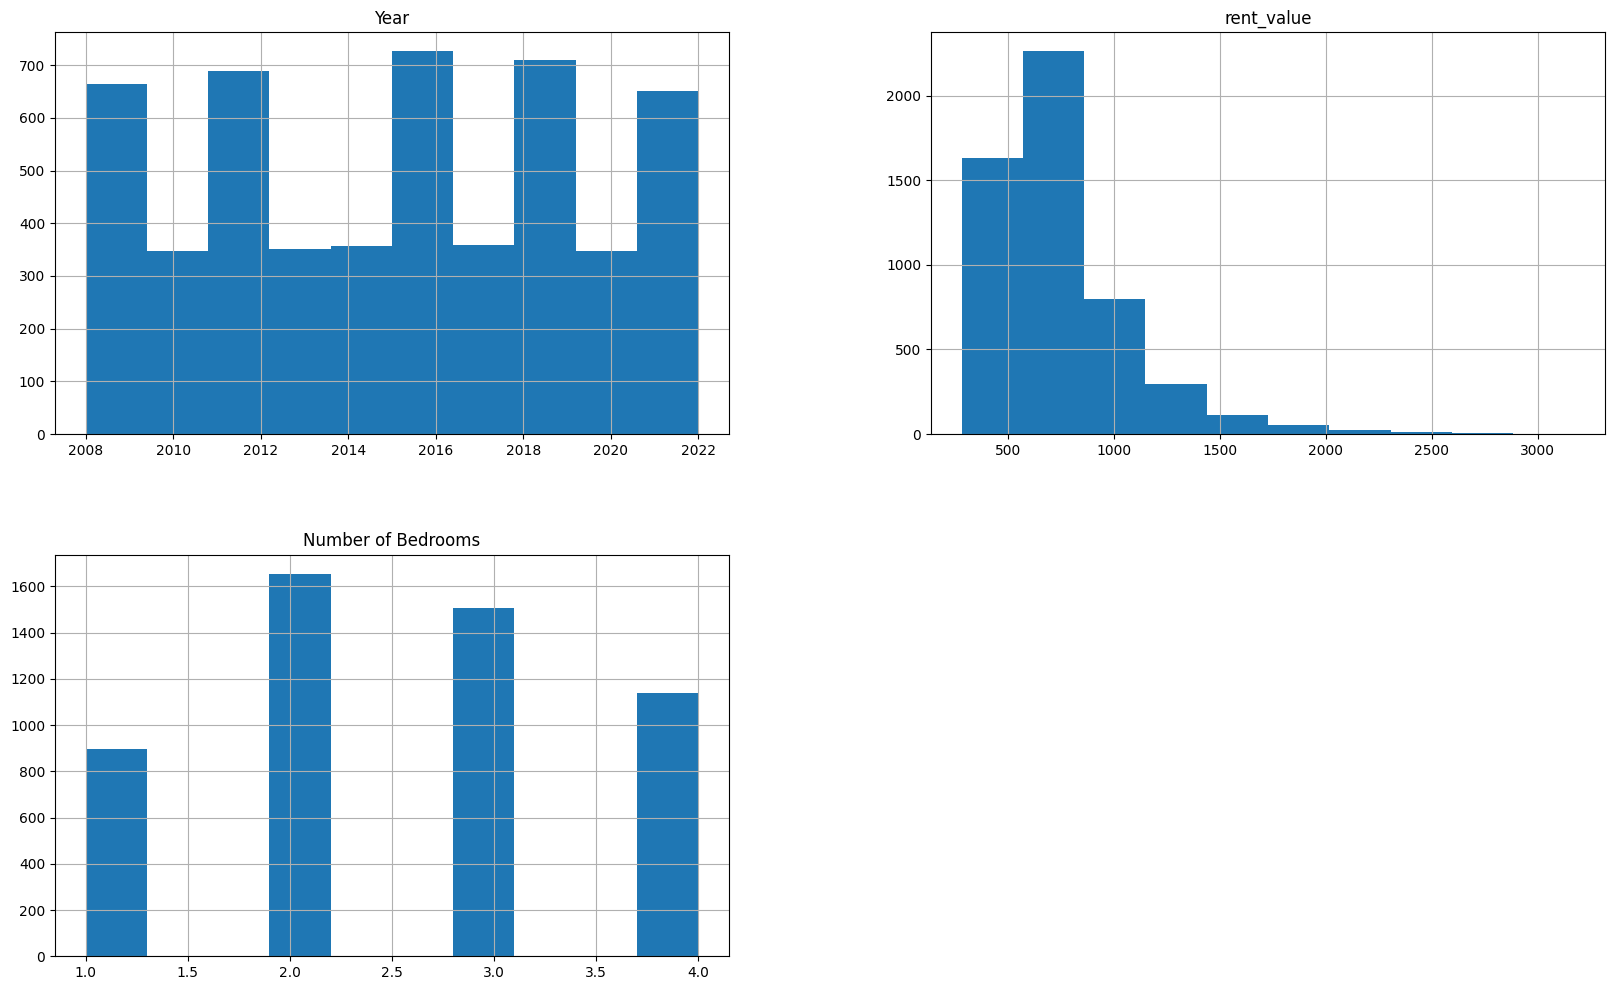

In [46]:
rent_df[['Year', 'rent_value', "Number of Bedrooms"]].hist(figsize=(20,12))

<ipython-input-47-1823801e39dd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rent_df.corr(), annot=True, cmap= "YlGnBu")


<Axes: >

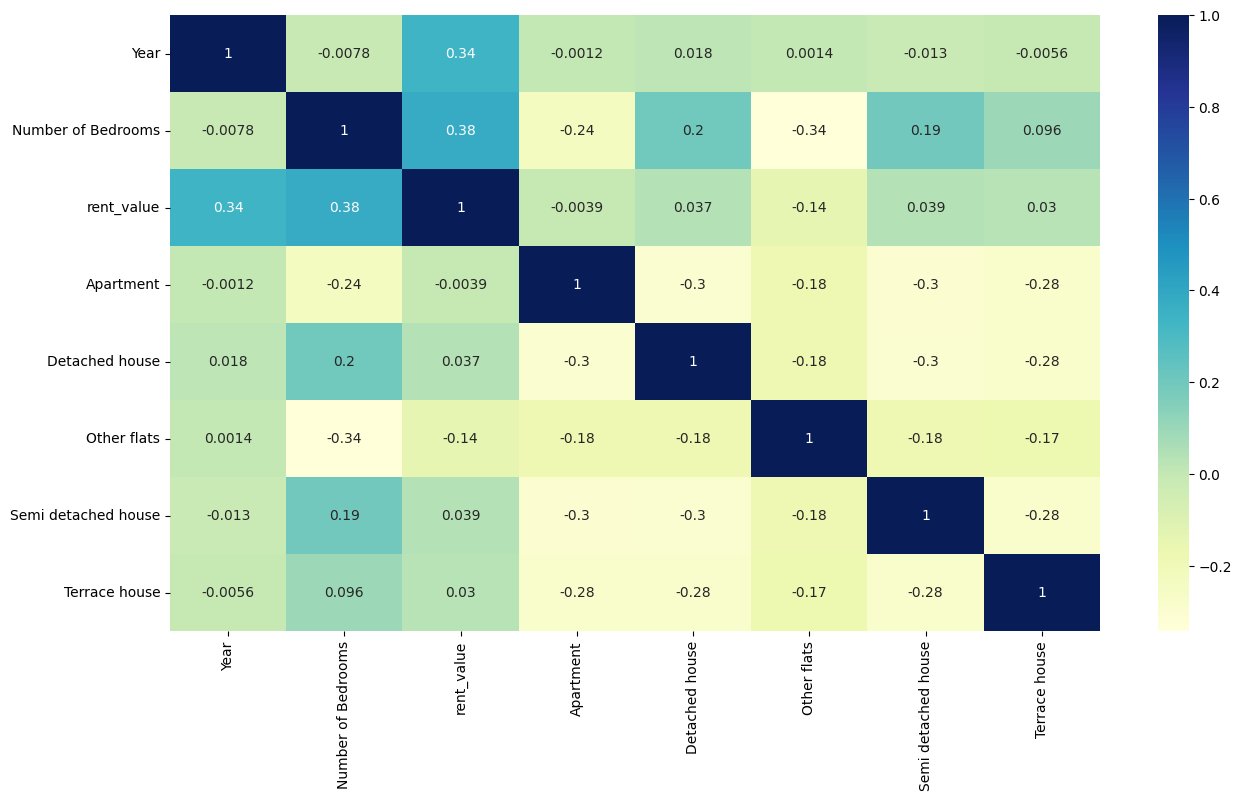

In [47]:
plt.figure(figsize= (15,8))
sns.heatmap(rent_df.corr(), annot=True, cmap= "YlGnBu")

#Exploratory Data Analysis - Disposable Income df

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'avg_disposable_income'}>]], dtype=object)

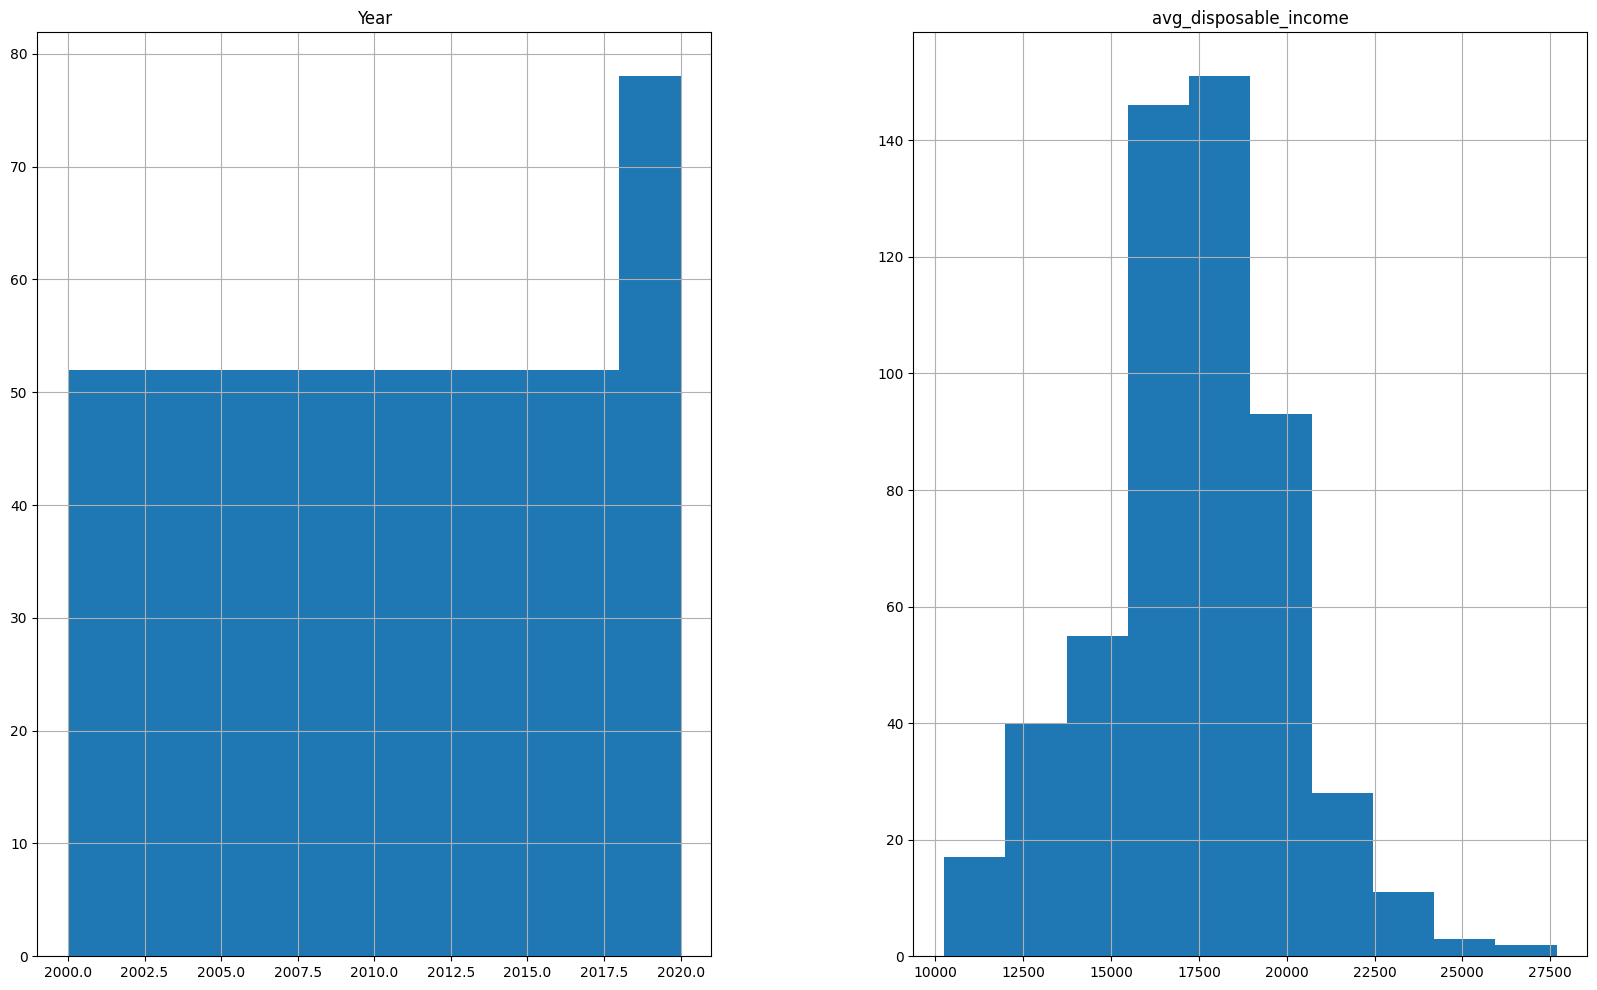

In [48]:
d_i_df.hist(figsize=(20,12))

<ipython-input-49-136ebed4f522>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(d_i_df.corr(), annot=True, cmap= "YlGnBu")


<Axes: >

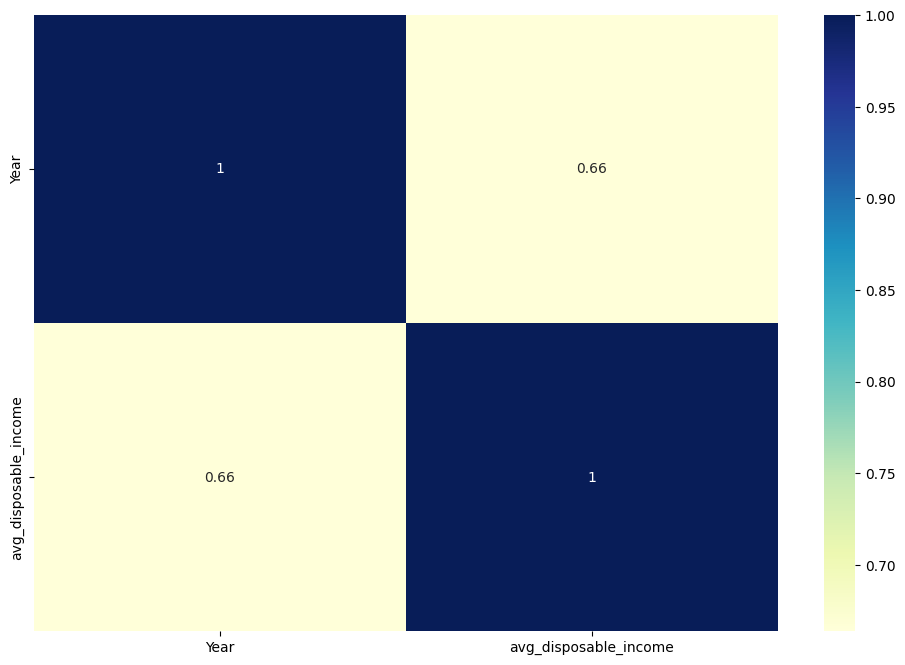

In [49]:
plt.figure(figsize= (12,8))
sns.heatmap(d_i_df.corr(), annot=True, cmap= "YlGnBu")

#Exploratory Data Analysis - House Purchases df

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'house_purchase_price'}>]], dtype=object)

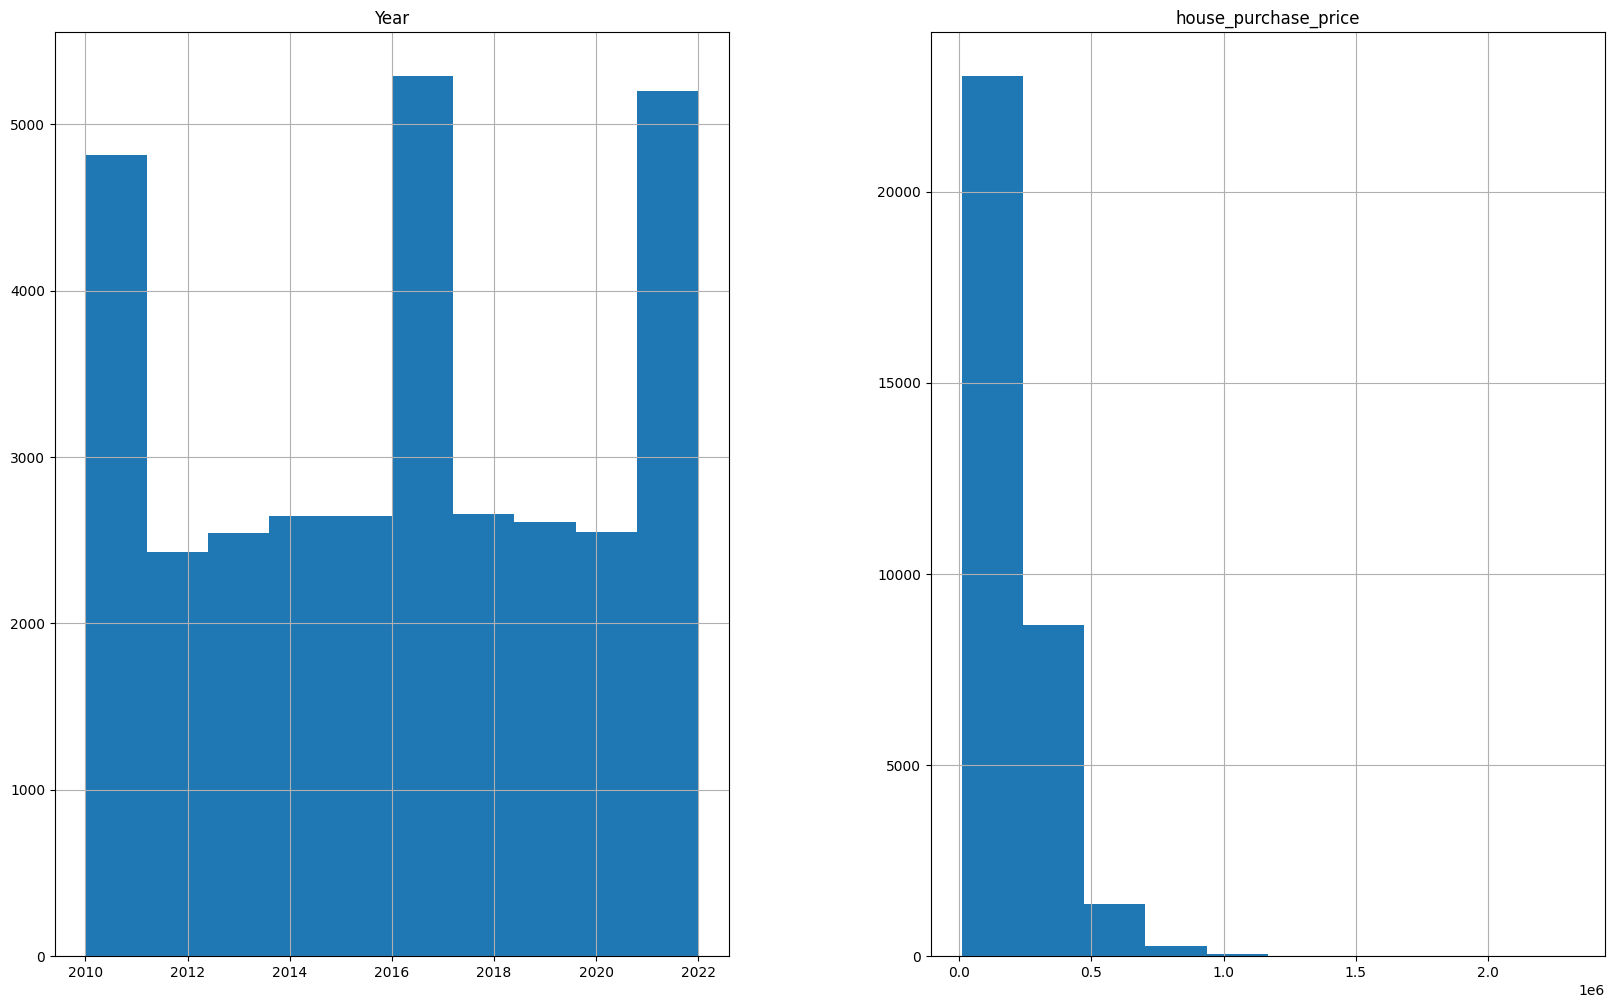

In [50]:
h_p_df.hist(figsize=(20,12))

<ipython-input-51-de1d26b5bb66>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(h_p_df.corr(), annot=True, cmap= "YlGnBu")


<Axes: >

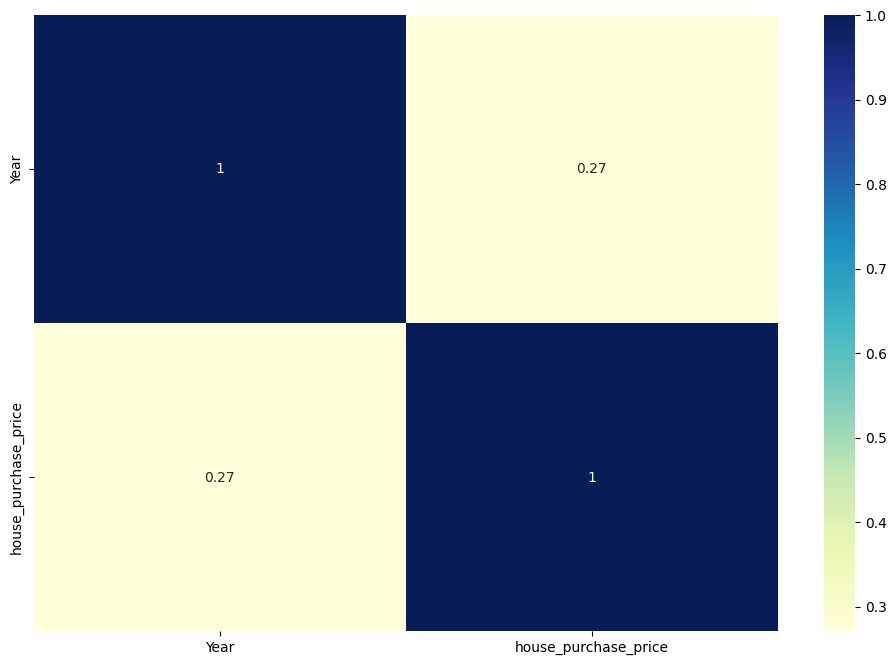

In [51]:
plt.figure(figsize= (12,8))
sns.heatmap(h_p_df.corr(), annot=True, cmap= "YlGnBu")

#Merging the dataframes into 1 dataframe

##Data preprocessing - combined df

In [52]:
cb_df = pd.merge(rent_df, d_i_df, on= ['Year', "region"])
cb_df = pd.merge(cb_df, h_p_df, on= ['Year', "region"])

In [53]:
cb_df

,Year,Number of Bedrooms,rent_value,region,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,Type of Dwelling,Dwelling Status,Stamp Duty Event,house_purchase_price
0,2010,1,591.15,South_West,0,1,0,0,0,19023.94,Apartment,New,Filings,324146.0
1,2010,1,591.15,South_West,0,1,0,0,0,19023.94,Apartment,New,Filings,232682.0
2,2010,1,591.15,South_West,0,1,0,0,0,19023.94,Apartment,New,Executions,448325.0
3,2010,1,591.15,South_West,0,1,0,0,0,19023.94,Apartment,New,Executions,280913.0
4,2010,1,591.15,South_West,0,1,0,0,0,19023.94,Apartment,Existing,Filings,160000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524971,2020,4,1115.14,Midland,0,0,0,0,1,19728.69,House,Existing,Filings,187878.0
4524972,2020,4,1115.14,Midland,0,0,0,0,1,19728.69,House,Existing,Executions,211325.0
4524973,2020,4,1115.14,Midland,0,0,0,0,1,19728.69,House,Existing,Executions,129422.0
4524974,2020,4,1115.14,Midland,0,0,0,0,1,19728.69,House,Existing,Executions,172851.0


In [54]:
cb_df = cb_df.drop("Type of Dwelling", "columns")
cb_df = cb_df.drop("Dwelling Status", "columns")
cb_df = cb_df.drop("Stamp Duty Event", "columns")

<ipython-input-54-6ef255389c76>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cb_df = cb_df.drop("Type of Dwelling", "columns")
<ipython-input-54-6ef255389c76>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cb_df = cb_df.drop("Dwelling Status", "columns")
<ipython-input-54-6ef255389c76>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cb_df = cb_df.drop("Stamp Duty Event", "columns")


In [55]:
cb_df.isna().sum()

Year                     0
Number of Bedrooms       0
rent_value               0
region                   0
Apartment                0
Detached house           0
Other flats              0
Semi detached house      0
Terrace house            0
avg_disposable_income    0
house_purchase_price     0
dtype: int64

In [56]:
#The merged dataset is too large, so a sample is taken
cb_sample_df = cb_df.sample(frac=0.003)

In [57]:
cb_sample_df = cb_sample_df.sort_values('Year')

In [58]:
cb_sample_df = cb_sample_df.join(pd.get_dummies(cb_sample_df["region"])).drop(["region"], axis=1)

creating a df with an equal amount of rows for each year

In [59]:
samples = []
for year in cb_sample_df['Year'].unique():
    s = cb_sample_df.loc[cb_sample_df['Year']== year].sample(n=1000).reset_index(drop=True)
    samples.append(s)

equal_sample_df = pd.concat(samples, axis=0)

#cb_sample_df['Year'].sample(n=3500)
#for year in cb_sample_df['Year']:
 # cb_sample_df = cb_sample_df['Year'].sample(n=350000)

In [60]:
S_yr_counts = equal_sample_df['Year'].value_counts()
S_yr_counts

2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
Name: Year, dtype: int64

In [61]:
equal_sample_df.head()

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West
0,2010,4,713.58,0,1,0,0,0,19155.83,180602.0,0,0,0,1,0,0,0,0
1,2010,2,459.38,0,0,0,0,1,16361.12,237500.0,1,0,0,0,0,0,0,0
2,2010,4,773.74,0,0,0,0,1,17357.20,219240.0,0,0,0,0,0,1,0,0
3,2010,3,462.92,1,0,0,0,0,18163.13,192238.0,1,0,0,0,0,0,0,0
4,2010,2,406.83,0,0,1,0,0,18163.13,201525.0,1,0,0,0,0,0,0,0


In [62]:
cb_sample_df

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West
251529,2010,1,336.01,0,0,1,0,0,15917.19,184596.0,1,0,0,0,0,0,0,0
148874,2010,2,557.25,0,0,0,0,1,18141.53,194769.0,0,0,0,1,0,0,0,0
101858,2010,4,861.69,0,0,0,0,1,19003.42,284146.0,0,0,1,0,0,0,0,0
250023,2010,1,285.03,0,0,1,0,0,15917.19,126965.0,1,0,0,0,0,0,0,0
126939,2010,3,583.98,0,0,0,0,1,19049.70,198433.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198747,2020,1,1080.35,1,0,0,0,0,23554.44,271008.0,0,0,1,0,0,0,0,0
4158863,2020,2,889.84,0,0,0,1,0,19952.30,432434.0,0,0,0,0,0,0,0,1
4131539,2020,2,1084.70,0,0,0,0,1,23855.61,122013.0,0,0,0,0,0,0,1,0
4340070,2020,1,482.78,1,0,0,0,0,19697.49,143875.0,1,0,0,0,0,0,0,0


In [63]:
yr_counts = cb_df['Year'].value_counts()

yr_counts
#taking the same number of values for each year:
#for i in range(37000):


2015    440616
2018    439723
2017    436702
2014    434789
2016    433232
2019    411810
2013    409126
2020    399005
2010    374425
2012    372906
2011    372642
Name: Year, dtype: int64

#Exploratory Data Analaysis - Combined df

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'rent_value'}>],
       [<Axes: title={'center': 'Number of Bedrooms'}>,
        <Axes: title={'center': 'avg_disposable_income'}>],
       [<Axes: title={'center': 'house_purchase_price'}>, <Axes: >]],
      dtype=object)

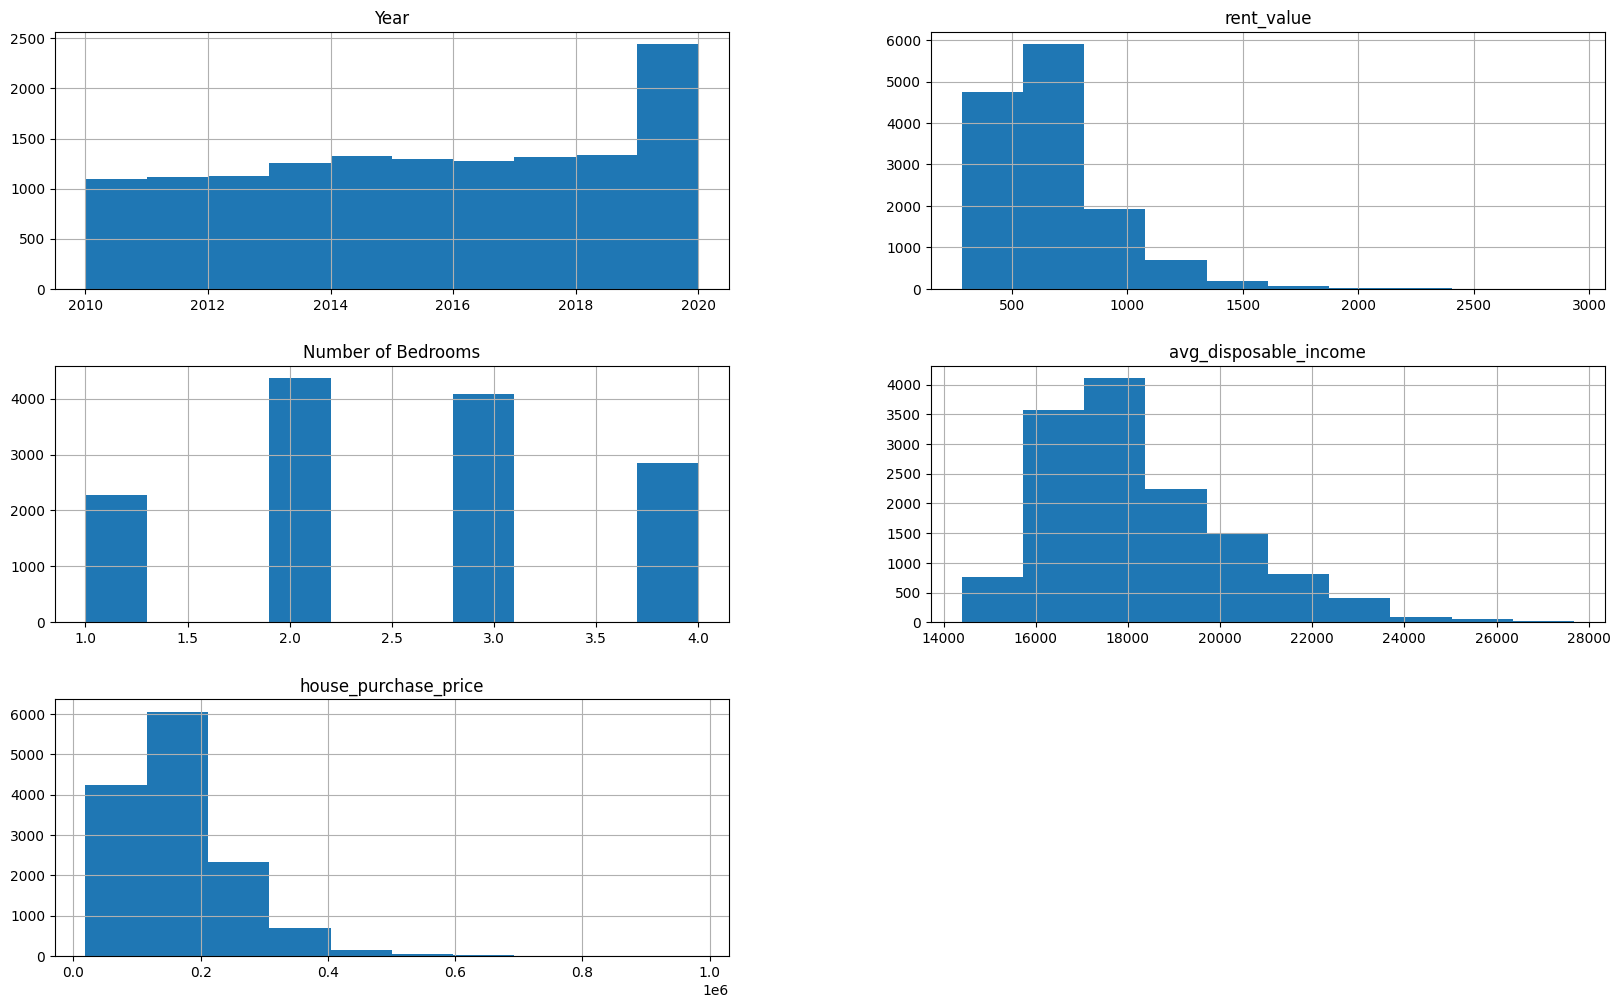

In [64]:
cb_sample_df[['Year', 'rent_value', 'Number of Bedrooms', 'avg_disposable_income', 'house_purchase_price']].hist(figsize=(20,12))

<Axes: >

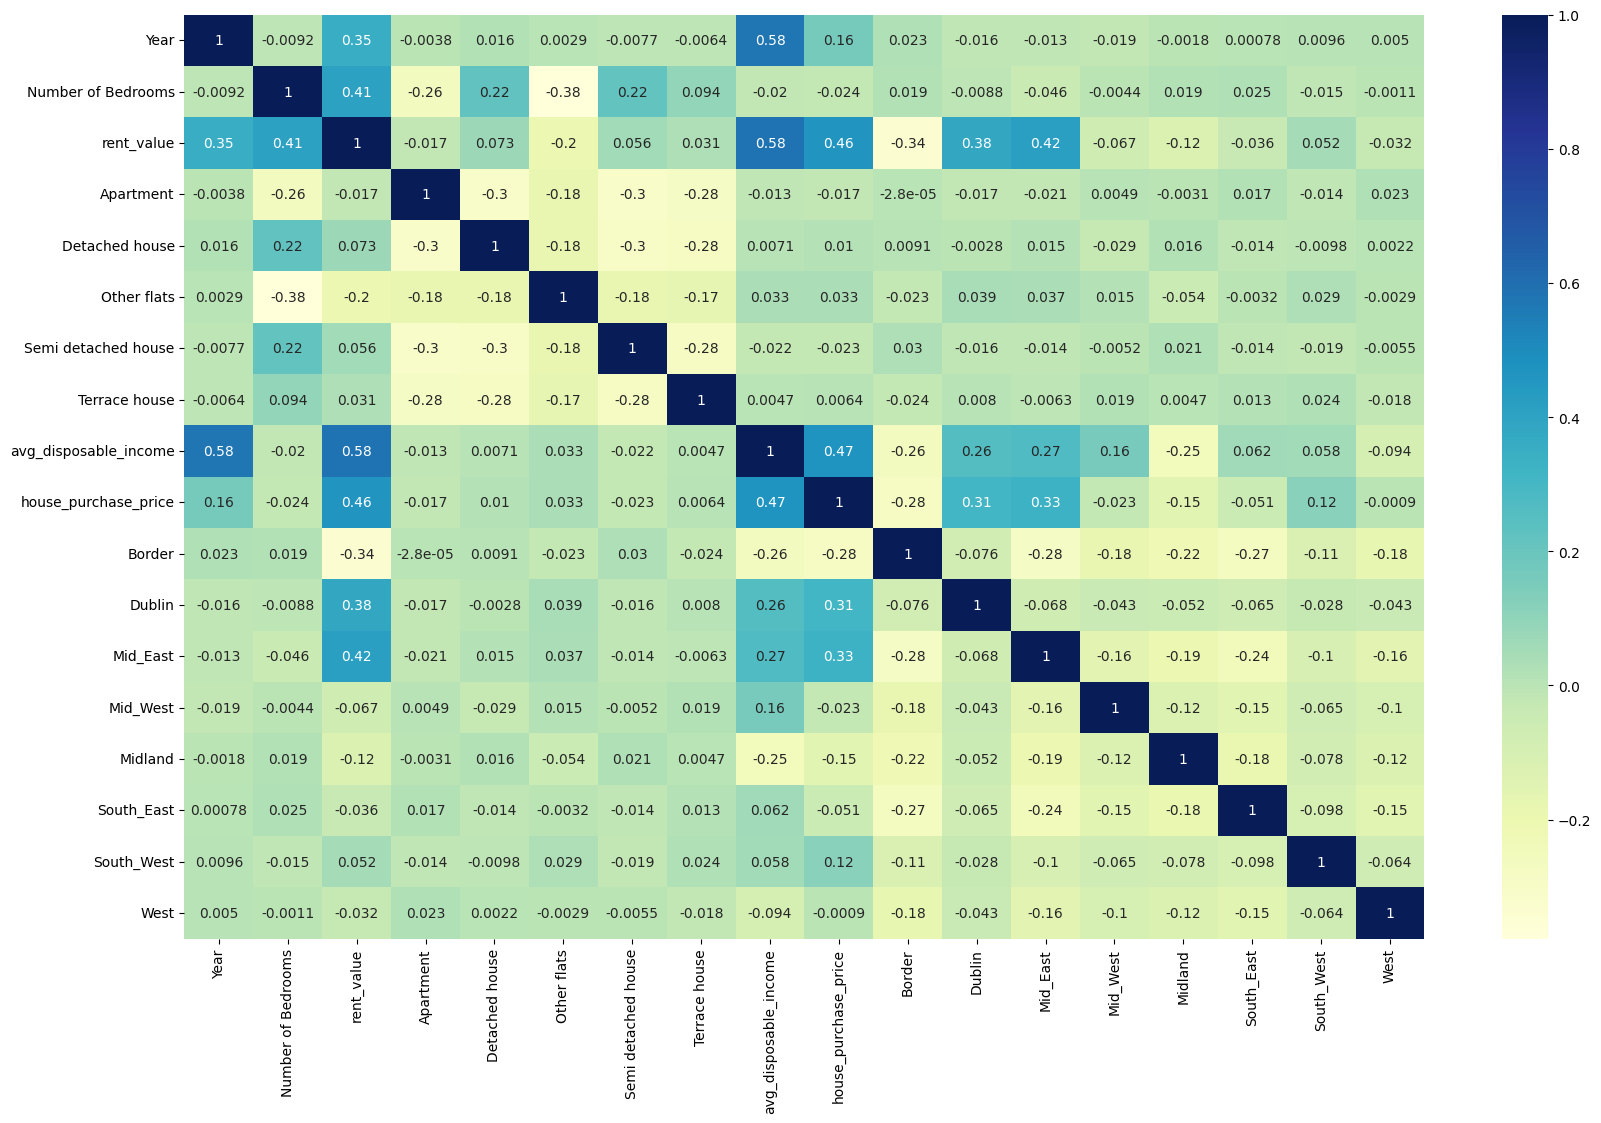

In [65]:
plt.figure(figsize= (20,12))
sns.heatmap(cb_sample_df.corr(), annot=True, cmap= "YlGnBu")

#line plots visualizing the house price and rent price data

<Axes: xlabel='Year'>

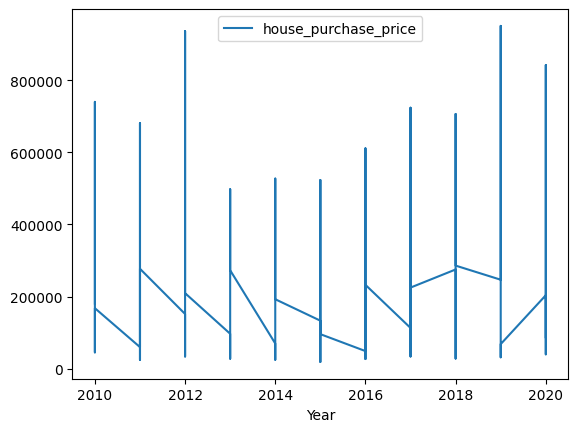

In [66]:
equal_sample_df.plot.line(x = "Year", y = "house_purchase_price", use_index = True)

<Axes: xlabel='Year'>

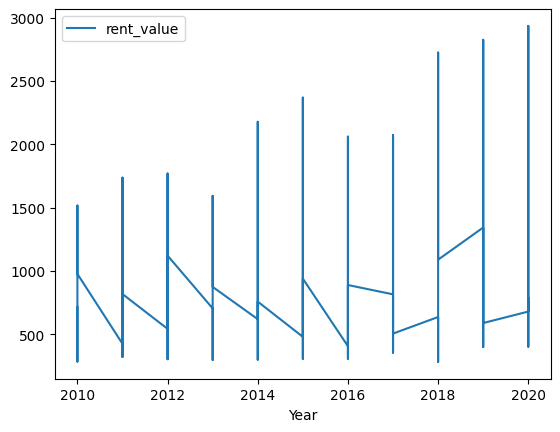

In [67]:
equal_sample_df.plot.line(x = "Year", y = "rent_value", use_index = True)

lets create a new column that shows the value 2 year in the future (house purchase value)

In [68]:
#cb_df['next_year_HPP'] = cb_df['house_purchase_price'].shift(-2)
#cb_df['next_year_RV'] = cb_df['rent_value'].shift(-2)
#cb_df.loc[cb_df['Year']  7]

#Creating models for the combined df

In [69]:
cb_sample_df

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West
251529,2010,1,336.01,0,0,1,0,0,15917.19,184596.0,1,0,0,0,0,0,0,0
148874,2010,2,557.25,0,0,0,0,1,18141.53,194769.0,0,0,0,1,0,0,0,0
101858,2010,4,861.69,0,0,0,0,1,19003.42,284146.0,0,0,1,0,0,0,0,0
250023,2010,1,285.03,0,0,1,0,0,15917.19,126965.0,1,0,0,0,0,0,0,0
126939,2010,3,583.98,0,0,0,0,1,19049.70,198433.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198747,2020,1,1080.35,1,0,0,0,0,23554.44,271008.0,0,0,1,0,0,0,0,0
4158863,2020,2,889.84,0,0,0,1,0,19952.30,432434.0,0,0,0,0,0,0,0,1
4131539,2020,2,1084.70,0,0,0,0,1,23855.61,122013.0,0,0,0,0,0,0,1,0
4340070,2020,1,482.78,1,0,0,0,0,19697.49,143875.0,1,0,0,0,0,0,0,0


##Train test split 1: Target = house purchase price

In [70]:
X_cb1 = cb_sample_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_cb1 = cb_sample_df['house_purchase_price']

In [71]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb1,y_cb1, test_size= 0.2)

##Train test split 2: Target = rent price

In [72]:
X_cb2 = cb_sample_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_cb2 = cb_sample_df['rent_value']

In [73]:
X_train_cb2, X_test_cb2, y_train_cb2, y_test_cb2 = train_test_split(X_cb2,y_cb2, test_size= 0.2)

In [74]:
#cb_df['Year'] = pd.to_datetime(cb_df['Year'])
#cb_df = cb_df.sort_values(by = 'Year')

##linear regression 1:
##Target = house purchase price

In [75]:
reg = LinearRegression()
reg.fit(X_train_cb, y_train_cb)


LinearRegression()

In [76]:
LR_1_pred = reg.predict(X_test_cb)

In [77]:
np.sqrt(mean_squared_error(y_test_cb, LR_1_pred))

71262.6621516757

In [78]:
reg.score(X_test_cb, y_test_cb)

0.32806095005515723

**Lets standardize the data using standard scalar to try to improve the score**

In [79]:
scalar = StandardScaler()
X_train_s = scalar.fit_transform(X_train_cb)
reg.fit(X_train_s, y_train_cb)

LinearRegression()

In [80]:
X_test_s = scalar.transform(X_test_cb)
reg.score(X_test_s, y_test_cb)

0.3280609500551568

##linear regression 2:
##Target = rent price

In [81]:
reg2 = LinearRegression()
reg2.fit(X_train_cb2, y_train_cb2)

LinearRegression()

In [82]:
LR_2_pred = reg2.predict(X_test_cb2)

In [83]:
np.sqrt(mean_squared_error(y_test_cb2, LR_2_pred))

129.18236154172504

In [84]:
reg2.score(X_test_cb2, y_test_cb2)

0.7404836007795534

**Lets standardize the data using standard scalar to try to improve the score**

In [85]:
scalar = StandardScaler()
X_train_s2 = scalar.fit_transform(X_train_cb2)
reg2.fit(X_train_s2, y_train_cb2)

LinearRegression()

In [86]:
X_test_s2 = scalar.transform(X_test_cb2)
reg2.score(X_test_s2, y_test_cb2)

0.740483600779307

##decision tree model 1:
##Target = house purchase price

In [87]:
regr_cb = DecisionTreeRegressor(max_depth=6)
regr_cb.fit(X_train_cb, y_train_cb)
pred = regr_cb.predict(X_test_cb)

In [88]:
regr_cb.score(X_test_cb, y_test_cb)

0.3499857350786991

In [89]:
np.sqrt(mean_squared_error(y_test_cb, pred))

70090.40113575474

###Cross validation

In [90]:
from sklearn.model_selection import GridSearchCV

regr_DTR = DecisionTreeRegressor()

param_grid={"splitter":["best","random"],
            "max_depth" : [3,5,7,9,11,12],
           "min_samples_leaf":[3,4,5,6,7,8,9,10]
}

grid_search_DTR = GridSearchCV(regr_DTR, param_grid, cv= 5,
                           scoring= "neg_mean_squared_error",
                           return_train_score=True)
grid_search_DTR.fit(X_train_cb, y_train_cb)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 7, 9, 11, 12],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [91]:
grid_search_DTR.best_estimator_

DecisionTreeRegressor(max_depth=9, min_samples_leaf=10, splitter='random')

In [92]:
best_DTR = grid_search_DTR.best_estimator_
pred_DTR = best_DTR.predict(X_test_cb)

In [93]:
np.sqrt(mean_squared_error(y_test_cb, pred_DTR))

68347.22974003613

In [94]:
best_DTR.score(X_test_cb, y_test_cb)

0.38191581796029284

**function for creating trees using pydot**

In [95]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

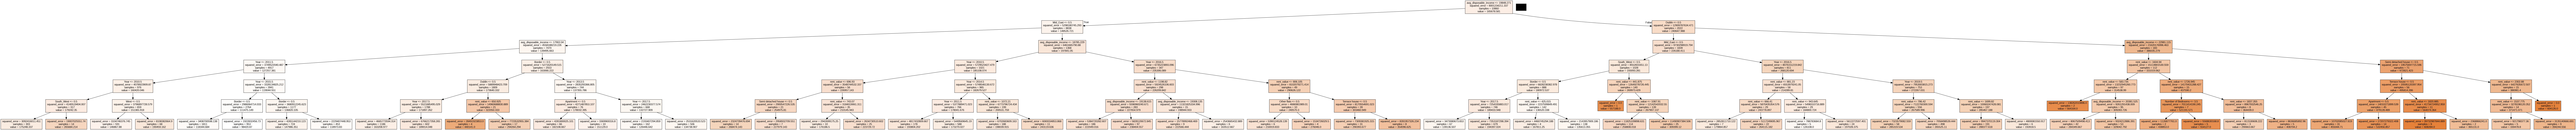

In [96]:
graph, = print_tree(regr_cb, features=X_cb1.columns)
Image(graph.create_png())

Text(0, 0.5, 'y_test')

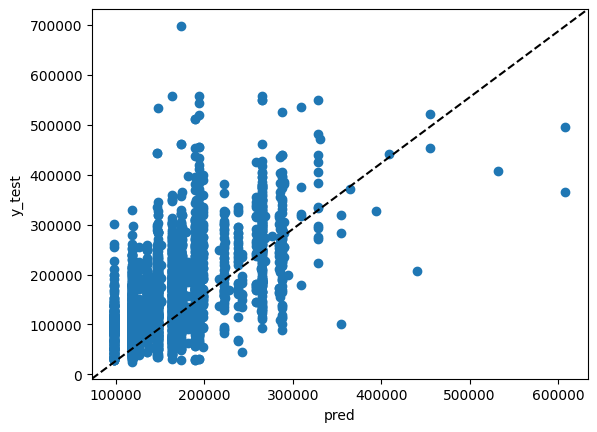

In [97]:
plt.scatter(pred, y_test_cb, label='house_purchase_price')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

##decision tree model 2:
##Target = rent price

In [98]:
regr_cb_2nd = DecisionTreeRegressor(max_depth=10)
regr_cb_2nd.fit(X_train_cb2, y_train_cb2)
pred_2nd = regr_cb_2nd.predict(X_test_cb2)

In [99]:
regr_cb_2nd.score(X_test_cb2, y_test_cb2)

0.7871307591647845

In [100]:
np.sqrt(mean_squared_error(y_test_cb2, pred_2nd))

116.99768585976936

###Cross validation

In [101]:
from sklearn.model_selection import GridSearchCV

regr_DTR2 = DecisionTreeRegressor()

param_grid ={"splitter":["best","random"],
            "max_depth" : [3,5,7,9,11,12],
           "min_samples_leaf":[3,4,5,6,7,8,9,10]
}

grid_search_DTR2 = GridSearchCV(regr_DTR2, param_grid, cv= 5,
                           scoring= "neg_mean_squared_error",
                           return_train_score=True)
grid_search_DTR2.fit(X_train_cb2, y_train_cb2)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 7, 9, 11, 12],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [102]:
grid_search_DTR2.best_estimator_

DecisionTreeRegressor(max_depth=12, min_samples_leaf=7, splitter='random')

In [103]:
best_DTR2 = grid_search_DTR2.best_estimator_
pred_DTR2 = best_DTR2.predict(X_test_cb2)

In [104]:
np.sqrt(mean_squared_error(y_test_cb2, pred_DTR2))

110.0999968377488

In [105]:
best_DTR2.score(X_test_cb2, y_test_cb2)

0.8114906131671332

Text(0, 0.5, 'y_test')

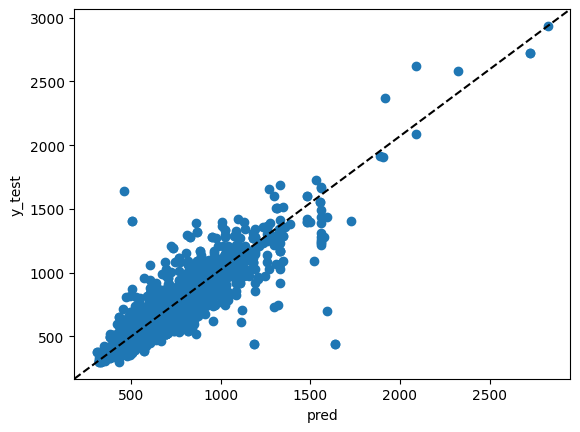

In [106]:
plt.scatter(pred_2nd, y_test_cb2, label='rent_value')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

**We will now use the random forest regressor to try to imrpove the model**

##Random forest model 1:
##Target = house purchase price

In [107]:
rf_cb = RandomForestRegressor(max_features='sqrt', random_state=1)
rf_cb.fit(X_train_cb, y_train_cb)

RandomForestRegressor(max_features='sqrt', random_state=1)

Text(0, 0.5, 'y_test')

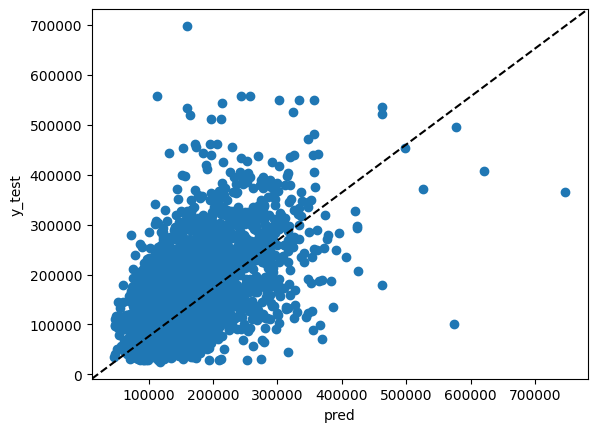

In [108]:
pred = rf_cb.predict(X_test_cb)
#pred_prob=rf.predict_proba(test)[:, 1]

plt.scatter(pred, y_test_cb, label='house_purchase_price')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [109]:
np.sqrt(mean_squared_error(y_test_cb, pred))

76621.88395506596

In [110]:
rf_cb.score(X_test_cb, y_test_cb)

0.22319600806438988

##Random forest model 2:
##Target = rent price

In [111]:
rf_cb2 = RandomForestRegressor(max_features='sqrt', random_state=1)
rf_cb2.fit(X_train_cb2, y_train_cb2)

RandomForestRegressor(max_features='sqrt', random_state=1)

Text(0, 0.5, 'y_test')

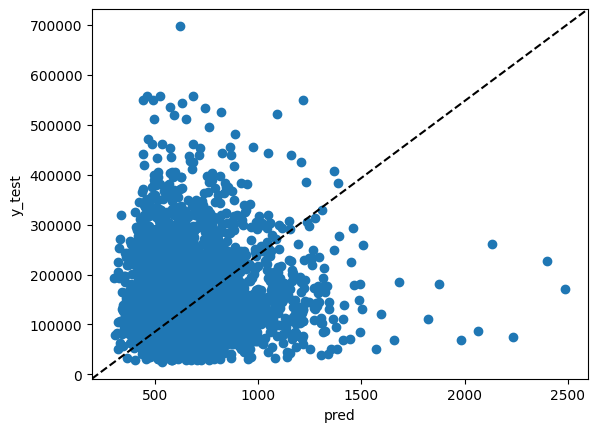

In [112]:
pred2 = rf_cb2.predict(X_test_cb2)
#pred_prob=rf.predict_proba(test)[:, 1]

plt.scatter(pred2, y_test_cb, label='rent_value')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [113]:
np.sqrt(mean_squared_error(y_test_cb2, pred2))

110.42713754327265

In [114]:
rf_cb2.score(X_test_cb2, y_test_cb2)

0.8103687109975916

###Cross Validation

####Grid search 1:
###Target = house purchse value

**We will now use cross validation to try to improve the model**

In [115]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

param_grid = {
    "n_estimators": [50,100,150],
    "max_features": [8,12,16],
    "min_samples_split": [10,15,20]
}

grid_search = GridSearchCV(forest, param_grid, cv= 5,
                           scoring= "neg_mean_squared_error",
                           return_train_score=True)
grid_search.fit(X_train_cb, y_train_cb)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 12, 16],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [116]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, min_samples_split=20, n_estimators=150)

In [117]:
best_forest = grid_search.best_estimator_
pred = best_forest.predict(X_test_cb)


In [118]:
np.sqrt(mean_squared_error(y_test_cb, pred))

69185.01655408836

In [119]:
best_forest.score(X_test_cb, y_test_cb)

0.366670241388239

####Grid search 2:
###Target = rent value

In [120]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

param_grid = {
    "n_estimators": [50,100,150],
    "max_features": [8,12,16],
    "min_samples_split": [10,15,20]
}

grid_search2 = GridSearchCV(forest, param_grid, cv= 5,
                           scoring= "neg_mean_squared_error",
                           return_train_score=True)
grid_search2.fit(X_train_cb2, y_train_cb2)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 12, 16],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [121]:
grid_search2.best_estimator_

RandomForestRegressor(max_features=8, min_samples_split=10, n_estimators=150)

In [122]:
best_forest2 = grid_search2.best_estimator_
pred2 = best_forest2.predict(X_test_cb2)


In [123]:
np.sqrt(mean_squared_error(y_test_cb2, pred2))

104.74986813600432

In [124]:
best_forest2.score(X_test_cb2, y_test_cb2)

0.8293660919259017

**A slight improvement from the linear regression**
**We will now use randomized search cross validation**

###Randomized search

In [125]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


####Randomized search 1:
Target = house price value

In [126]:
rf_RS_cb = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_RS_cb,
                               param_distributions = random_grid,
                               n_iter = 50, cv = 2,
                               verbose=2, random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_cb, y_train_cb)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   random_state=42, verbose=2)

In [127]:
rf_random.best_params_

{'n_estimators': 325,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [128]:
best_random = rf_random.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)
pred_random = best_random.predict(X_test_cb)

In [129]:
np.sqrt(mean_squared_error(y_test_cb, pred_random))

68475.85259324317

In [130]:
best_random.score(X_test_cb, y_test_cb)

0.3795872800889937

####Randomized search 2:
Target = rent value

In [131]:
rf_RS_cb2 = RandomForestRegressor()
rf_random2 = RandomizedSearchCV(estimator = rf_RS_cb2,
                               param_distributions = random_grid,
                               n_iter = 50, cv = 2,
                               verbose=2, random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random2.fit(X_train_cb2, y_train_cb2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   random_state=42, verbose=2)

In [132]:
rf_random2.best_params_

{'n_estimators': 775,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [133]:
best_random2 = rf_random2.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)
pred_random2 = best_random2.predict(X_test_cb2)


In [134]:
np.sqrt(mean_squared_error(y_test_cb2, pred_random2))

104.44975514806958

In [135]:
best_random2.score(X_test_cb2, y_test_cb2)

0.8303424386122855

##XGBoost

###XGB 1

In [136]:
reg_xgb1 = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50) #stops early if no improvment after 50 trees
reg_xgb1.fit(X_train_cb, y_train_cb,
           eval_set=[(X_train_cb, y_train_cb), (X_test_cb, y_test_cb)],
           verbose=10)

[0]	validation_0-rmse:79618.86970	validation_1-rmse:78504.34277
[10]	validation_0-rmse:64749.40087	validation_1-rmse:68410.17960
[20]	validation_0-rmse:62608.46722	validation_1-rmse:68975.62423
[30]	validation_0-rmse:61148.16619	validation_1-rmse:69492.67343
[40]	validation_0-rmse:59618.85747	validation_1-rmse:70401.56017
[50]	validation_0-rmse:58144.37991	validation_1-rmse:71207.46198
[58]	validation_0-rmse:57260.94907	validation_1-rmse:71514.85247


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [137]:
reg_xgb1.score(X_test_cb, y_test_cb)

0.38214968529461646

###Feature importance

In [138]:
FI1 = pd.DataFrame(data = reg_xgb1.feature_importances_,
             index = reg_xgb1.feature_names_in_,
             columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

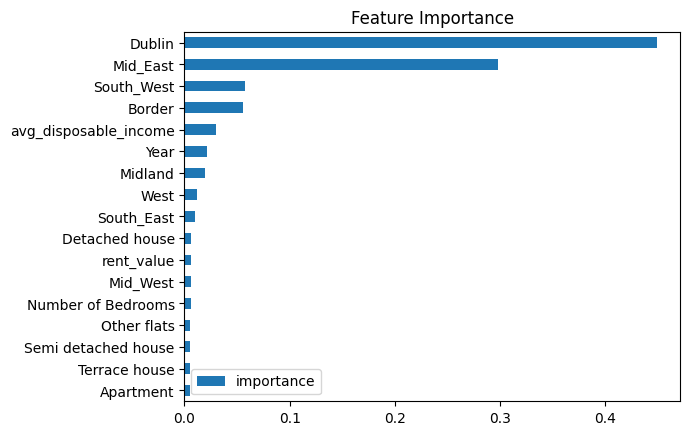

In [139]:
FI1.sort_values('importance').plot(kind= 'barh', title= 'Feature Importance')

###XGB 2

In [140]:
reg_xgb2 = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50) #stops early if no improvment after 50 trees
reg_xgb2.fit(X_train_cb2, y_train_cb2,
           eval_set=[(X_train_cb2, y_train_cb2), (X_test_cb2, y_test_cb2)],
           verbose=10)

[0]	validation_0-rmse:195.53794	validation_1-rmse:199.62502
[10]	validation_0-rmse:95.22235	validation_1-rmse:103.25024
[20]	validation_0-rmse:87.43274	validation_1-rmse:102.76851
[30]	validation_0-rmse:84.21166	validation_1-rmse:102.97701
[40]	validation_0-rmse:80.51699	validation_1-rmse:103.98520
[50]	validation_0-rmse:77.52382	validation_1-rmse:104.58893
[60]	validation_0-rmse:74.76650	validation_1-rmse:105.25925
[70]	validation_0-rmse:72.89867	validation_1-rmse:106.13435
[74]	validation_0-rmse:71.75338	validation_1-rmse:106.50430


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
reg_xgb2.score(X_test_cb2, y_test_cb2)

0.8362898315969588

###Feature importance

In [142]:
FI2 = pd.DataFrame(data = reg_xgb2.feature_importances_,
             index = reg_xgb2.feature_names_in_,
             columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

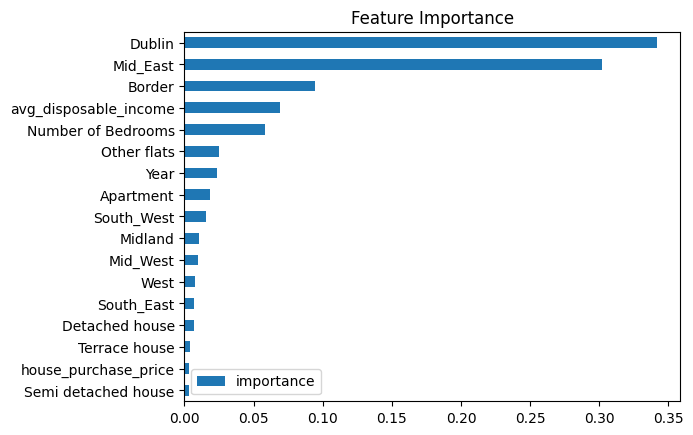

In [143]:
FI2.sort_values('importance').plot(kind= 'barh', title= 'Feature Importance')

##Train test split 3: Divided by year (DBY)
Training = before 2018,

Test = 2018 or later


We will use XGBRegressor to do some time series forecasting for this train test split (DYB)

In [145]:
train_TS = equal_sample_df.loc[equal_sample_df['Year'] < 2018]
test_TS = equal_sample_df.loc[equal_sample_df['Year'] >= 2018]

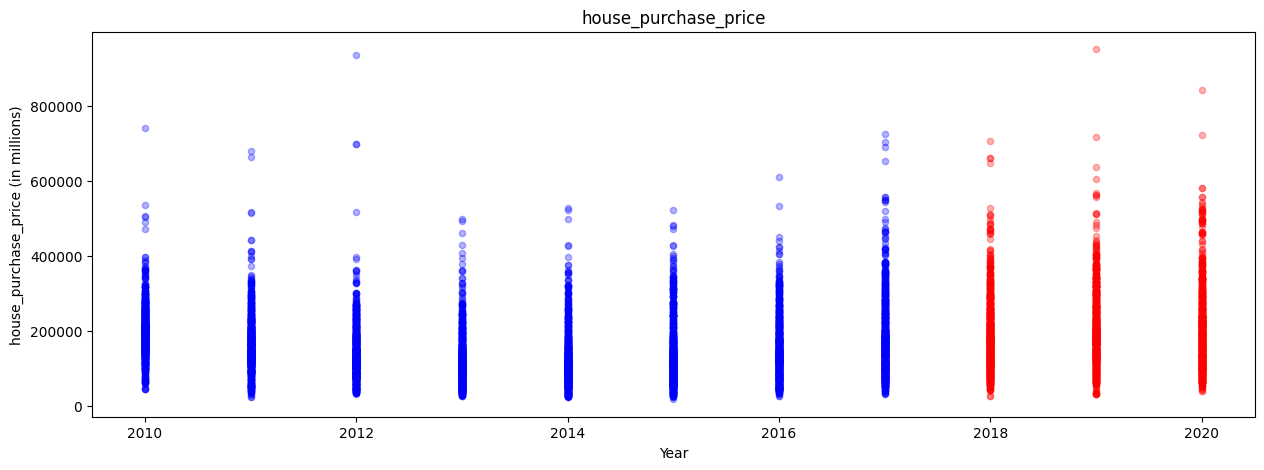

In [146]:
fig, ax = plt.subplots(figsize=(15,5))
train_TS.plot(x='Year', y='house_purchase_price', color= 'blue', kind= 'scatter', ax = ax, alpha= 0.3)
test_TS.plot(x='Year', y='house_purchase_price', color= 'red', kind= 'scatter', ax = ax, alpha= 0.3)
plt.xlabel("Year")
plt.ylabel("house_purchase_price (in millions)")
plt.title("house_purchase_price")
plt.show()

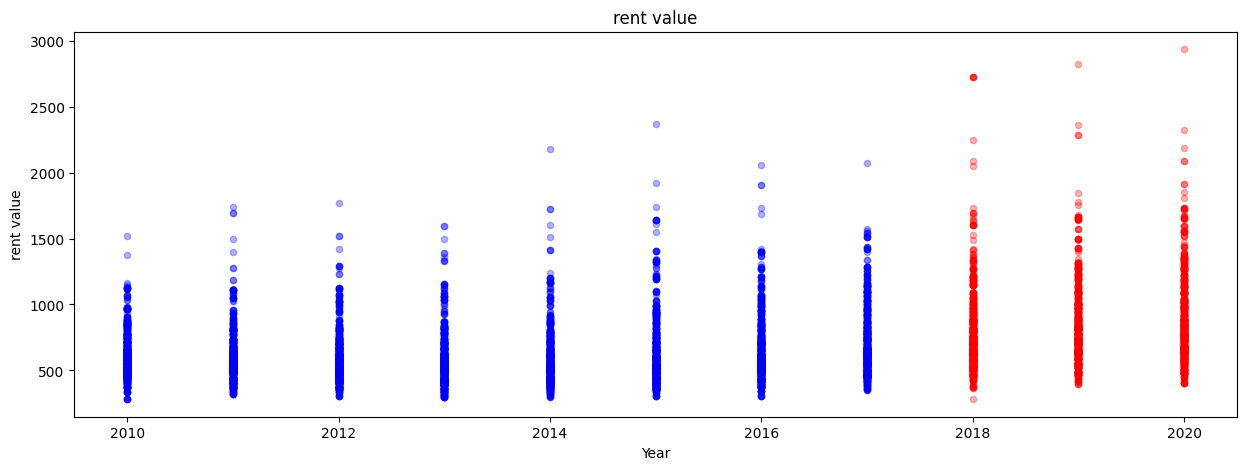

In [147]:
fig, ax = plt.subplots(figsize=(15,5))
train_TS.plot(x='Year', y='rent_value', color= 'blue', kind= 'scatter', ax = ax, alpha= 0.3)
test_TS.plot(x='Year', y='rent_value', color= 'red', kind= 'scatter', ax = ax, alpha= 0.3)
plt.xlabel("Year")
plt.ylabel("rent value")
plt.title("rent value")
plt.show()

###Train Test Split (DBY) Target = house_purchase_price



In [148]:
X_DBY_train = train_TS.drop(["house_purchase_price"], axis=1)
y_DBY_train = train_TS['house_purchase_price']

X_DBY_test = test_TS.drop(["house_purchase_price"], axis=1)
y_DBY_test = test_TS['house_purchase_price']

####XGBoost

In [149]:
reg_TS1 = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50) #stops early if no improvment after 50 trees
reg_TS1.fit(X_DBY_train, y_DBY_train,
           eval_set=[(X_DBY_train, y_DBY_train), (X_DBY_test, y_DBY_test)],
           verbose=25)

[0]	validation_0-rmse:71750.51431	validation_1-rmse:97529.81905
[25]	validation_0-rmse:55616.34446	validation_1-rmse:87494.17869
[50]	validation_0-rmse:52116.15438	validation_1-rmse:90082.46449
[58]	validation_0-rmse:50983.69043	validation_1-rmse:90376.60857


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
reg_TS1.score(X_DBY_test, y_DBY_test)

####Feature importance

In [151]:
FI = pd.DataFrame(data = reg_TS1.feature_importances_,
             index = reg_TS1.feature_names_in_,
             columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

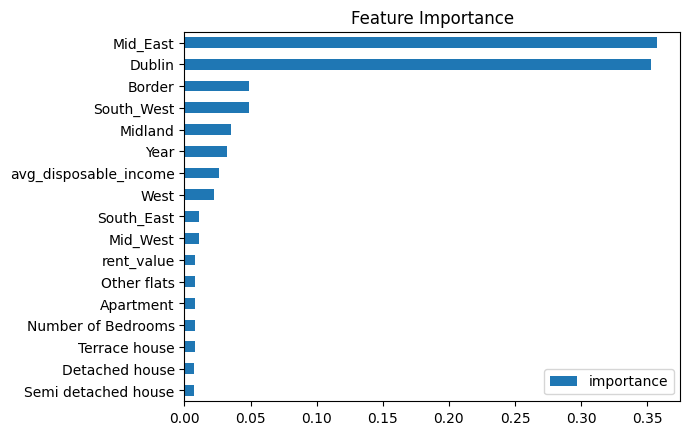

In [152]:
FI.sort_values('importance').plot(kind= 'barh', title= 'Feature Importance')

####Forecast on test set using trained model

In [153]:
test_TS['predictions'] = reg_TS1.predict(X_DBY_test)
equal_sample_df = equal_sample_df.merge(test_TS[['predictions']], how= 'left', left_index=True, right_index=True)


<ipython-input-153-62ac141e79b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_TS['predictions'] = reg_TS1.predict(X_DBY_test)


In [154]:
equal_sample_df

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West,predictions
0,2010,4,713.58,0,1,0,0,0,19155.83,180602.0,0,0,0,1,0,0,0,0,181549.453125
0,2010,4,713.58,0,1,0,0,0,19155.83,180602.0,0,0,0,1,0,0,0,0,197661.906250
0,2010,4,713.58,0,1,0,0,0,19155.83,180602.0,0,0,0,1,0,0,0,0,194381.906250
0,2011,3,425.12,0,1,0,0,0,15175.79,60000.0,1,0,0,0,0,0,0,0,181549.453125
0,2011,3,425.12,0,1,0,0,0,15175.79,60000.0,1,0,0,0,0,0,0,0,197661.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,2019,1,589.06,1,0,0,0,0,17662.86,68333.0,1,0,0,0,0,0,0,0,118310.867188
999,2019,1,589.06,1,0,0,0,0,17662.86,68333.0,1,0,0,0,0,0,0,0,116281.171875
999,2020,3,784.13,0,0,0,1,0,18321.79,87500.0,1,0,0,0,0,0,0,0,151049.109375
999,2020,3,784.13,0,0,0,1,0,18321.79,87500.0,1,0,0,0,0,0,0,0,118310.867188


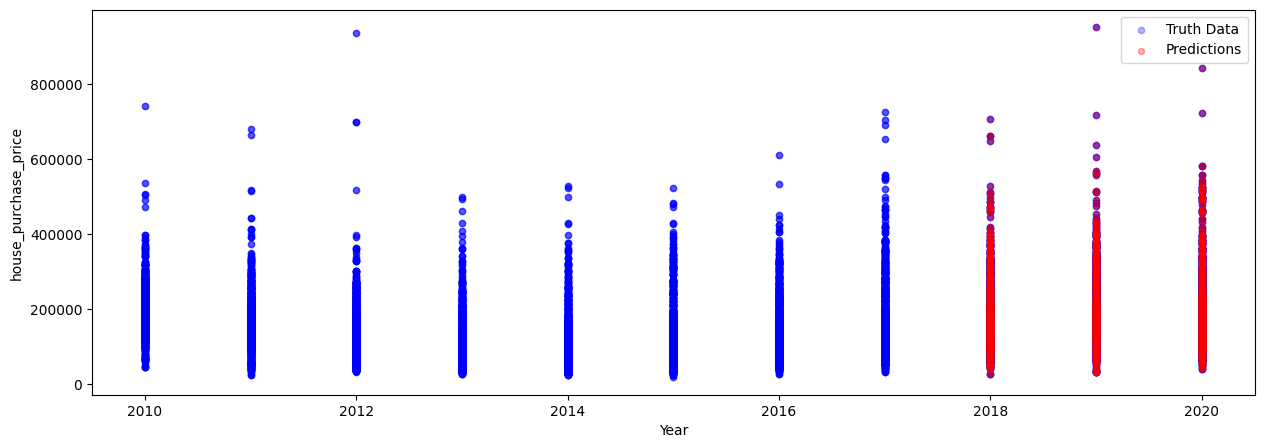

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
equal_sample_df.plot(x='Year', y='house_purchase_price', color= 'blue', kind= 'scatter', ax = ax, alpha= 0.3)
test_TS.plot(x='Year', y='house_purchase_price', color= 'red', kind= 'scatter', ax = ax, alpha= 0.3)
plt.legend(['Truth Data', 'Predictions'])
plt.show()

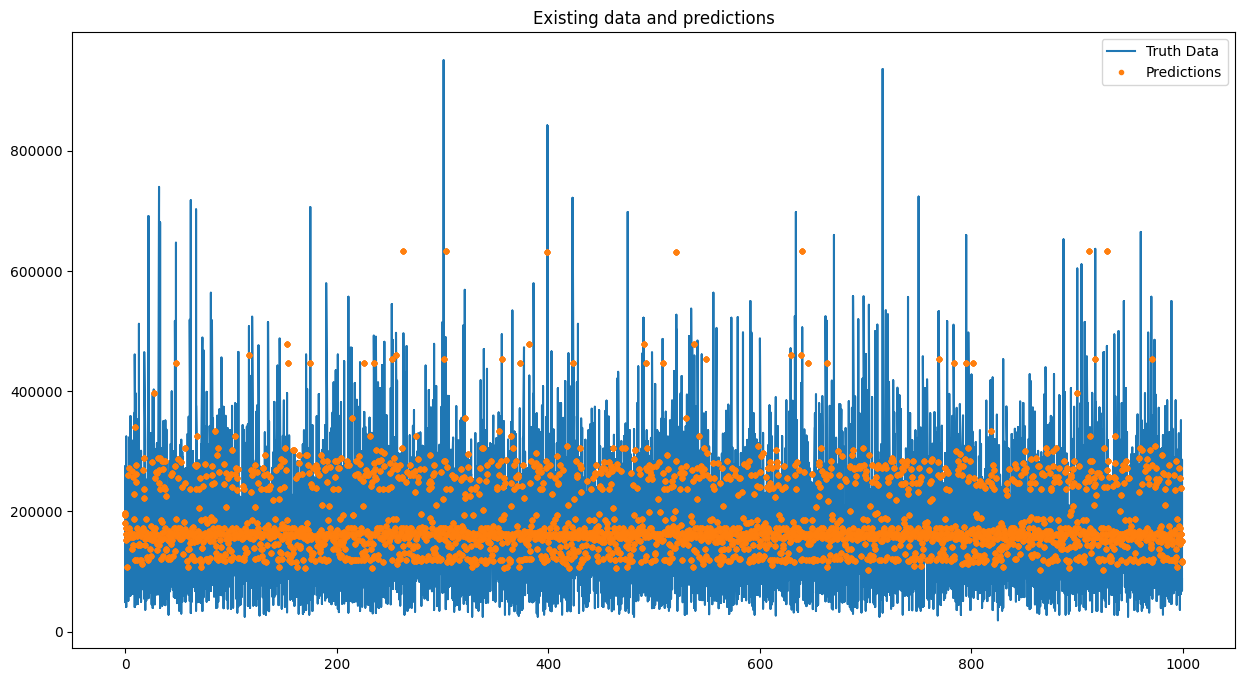

In [156]:
ax = equal_sample_df[['house_purchase_price']].plot(figsize=(15,8))
equal_sample_df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Existing data and predictions')
plt.show()

###Train Test Split (DBY) Target = rent_value

In [157]:
train_TS2 = equal_sample_df.loc[equal_sample_df['Year'] < 2018]
test_TS2 = equal_sample_df.loc[equal_sample_df['Year'] >= 2018]

In [158]:
X_DBY_train2 = train_TS2.drop(["rent_value"], axis=1)
y_DBY_train2 = train_TS2['rent_value']

X_DBY_test2 = test_TS2.drop(["rent_value"], axis=1)
y_DBY_test2 = test_TS2['rent_value']

####XGBoost

In [159]:
reg_TS2 = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50) #stops early if no improvment after 50 trees
reg_TS2.fit(X_DBY_train2, y_DBY_train2,
           eval_set=[(X_DBY_train2, y_DBY_train2), (X_DBY_test2, y_DBY_test2)],
           verbose=25)

[0]	validation_0-rmse:162.31479	validation_1-rmse:296.69723
[25]	validation_0-rmse:76.03968	validation_1-rmse:158.00742
[50]	validation_0-rmse:68.12438	validation_1-rmse:158.87461
[73]	validation_0-rmse:62.20292	validation_1-rmse:159.59907


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [160]:
reg_TS2.score(X_DBY_test2, y_DBY_test2)

0.6963347928149388

####Feature importance

In [161]:
FI = pd.DataFrame(data = reg_TS2.feature_importances_,
             index = reg_TS2.feature_names_in_,
             columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

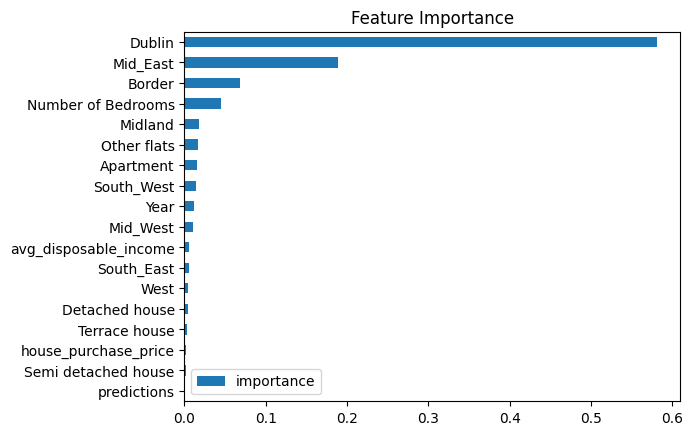

In [162]:
FI.sort_values('importance').plot(kind= 'barh', title= 'Feature Importance')

####Forecast on test set using trained model - NOT DONE. WAS PLANNING TO DO THIS FOR EACH REGION BUT WAS RESTRICTED BY TIME!!!

dividing the df by region

In [163]:
Dublin_df = equal_sample_df.loc[equal_sample_df['Dublin']==1]
South_East_df = equal_sample_df.loc[equal_sample_df['South_East']==1]
South_west_df = equal_sample_df.loc[equal_sample_df['South_West']==1]
West_df = equal_sample_df.loc[equal_sample_df['West']==1]
Midland_df = equal_sample_df.loc[equal_sample_df['Midland']==1]
Mid_East_df = equal_sample_df.loc[equal_sample_df['Mid_East']==1]
Mid_West_df = equal_sample_df.loc[equal_sample_df['Mid_West']==1]
Border_df = equal_sample_df.loc[equal_sample_df['Border']==1]


##Creating tables to show the results - house purchase price

In [164]:
results_house_purchase_value = {'Algorithm': ['linear regression', 'decision tree', 'grid search random forest', 'random search random forest', 'XGBoost'],
                                'RMSE': [71251.86157223086, 69218.34931607595, 68483.74043215027, 67859.24255997616, 68038.61449],
                                'R^2': [0.36509340019059655, 0.390902153187071, 0.3838658038824909, 0.3945996365286424, 0.41524933788985974]}

In [165]:
pd.DataFrame.from_dict(results_house_purchase_value)

,Algorithm,RMSE,R^2
0,linear regression,71251.861572,0.365093
1,decision tree,69218.349316,0.390902
2,grid search random forest,68483.740432,0.383866
3,random search random forest,67859.242560,0.394600
4,XGBoost,68038.614490,0.415249


##Creating tables to show the results - rent value

In [166]:
results_rent_value = {'Algorithm': ['linear regression', 'decision tree', 'grid search random forest', 'random search random forest', 'XGBoost'],
                      'RMSE': [125.90171437316953, 104.23812883185168, 100.968187630808, 102.84359536132274, 99.60653],
                      'R^2': [0.7599012357729493, 0.8402632870105703, 0.842517047991096, 0.8369365566585716, 0.8541430305306692]}

In [167]:
pd.DataFrame.from_dict(results_rent_value)

,Algorithm,RMSE,R^2
0,linear regression,125.901714,0.759901
1,decision tree,104.238129,0.840263
2,grid search random forest,100.968188,0.842517
3,random search random forest,102.843595,0.836937
4,XGBoost,99.606530,0.854143
